# W261 Final Project

#### *Anusha Munjuluri, Arvindh Ganesan, Kim Vignola, Christina Papadimitriou*

### Notebook Set-up

In [1]:
# imports
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import types
import pyspark.sql
import pyspark.sql.functions

In [2]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [3]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

## 1. Question Formulation

## 2. Algorithm Explanation

## 3. EDA & Discussion of Challenges

### 3.1 Data Loading

In [4]:
# take a look at the data
!head -n 1 data/train.txt

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16


In [4]:
# load the data
fullTrainRDD = sc.textFile('data/train.txt')
testRDD = sc.textFile('data/test.txt')

FIELDS = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26','Label']

In [7]:
# number of rows in train/test data
print(f"Number of records in train data: {fullTrainRDD.count()} ...")
print(f"Number of records in test data: {testRDD.count()} ...")

Number of records in train data: 45840617 ...
Number of records in test data: 6042135 ...


### 3.2 Creating Train and Test Split

In [5]:
# Generate 80/20 (pseudo)random train/test split 
trainRDD, heldOutRDD = fullTrainRDD.randomSplit([0.8,0.2], seed = 1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 9167871 records for evaluation and assigned 36672746 for training.


### 3.3 Pre-Processing

In [37]:
# helper functions
def parse(line):
    """
    Map line --> tuple of (features, label)
    """
    fields = line.split('\t')
    features,label = fields[1:], fields[0]
    return(features, label)

def edit_data_types(line):
    """
    Map tuple of (features, label) --> tuple of (formated features, label)
    
    * '' is replaced with NaN
    * numerical fields are converted to integers
    * make label column numeric
    """
    features, label = line[0], line[1]
    formated_features = []
    for i, value in enumerate(features):
        if value == '':
            formated_features.append('null') # replaced the np.nan with 'null' because spark doesnt recognize np.nan when filtering
        else:
            if i < 13:
                formated_features.append(float(value)) 
            else:
                formated_features.append(value)
    return (formated_features, int(label))

In [38]:
# Parsing, making '' as np.nan and converting numerical features and output label to int
trainRDDCached = trainRDD.map(parse).map(edit_data_types).cache()

In [39]:
print(trainRDDCached.take(1))

[([1.0, 1.0, 5.0, 0.0, 1382.0, 4.0, 15.0, 2.0, 181.0, 1.0, 2.0, 'null', 2.0, '68fd1e64', '80e26c9b', 'fb936136', '7b4723c4', '25c83c98', '7e0ccccf', 'de7995b8', '1f89b562', 'a73ee510', 'a8cd5504', 'b2cb9c98', '37c9c164', '2824a5f6', '1adce6ef', '8ba8b39a', '891b62e7', 'e5ba7672', 'f54016b9', '21ddcdc9', 'b1252a9d', '07b5194c', 'null', '3a171ecb', 'c5c50484', 'e8b83407', '9727dd16'], 0)]


### 3.4 Creating a toy RDD

In [65]:
# creating toy sample (run this once from cmd line and reuse the same sample)
!gshuf -n 1000 data/train.txt >> data/toy1000.txt

In [40]:
toyRDD = sc.textFile('data/toy1000.txt')
toyRDDCached = toyRDD.map(parse).map(edit_data_types).cache()

print(f"Number of records in toy data: {toyRDDCached.count()} ...")

Number of records in toy data: 1000 ...


In [41]:
print(toyRDDCached.take(1))

[([0.0, 478.0, 13.0, 'null', 3396.0, 194.0, 11.0, 13.0, 312.0, 0.0, 7.0, 'null', 'null', '05db9164', '207b2d81', '1757640a', '06148e59', '25c83c98', 'fbad5c96', 'f36791d8', '0b153874', 'a73ee510', 'c7009b63', '2714650d', '1a69f1c0', '9a88e2e2', '07d13a8f', '0c67c4ca', '8075af0c', 'e5ba7672', '395856b0', '21ddcdc9', 'b1252a9d', '8e4884c0', 'null', '423fab69', 'b936bfbe', '001f3601', 'f2fc1d6e'], 1)]


#### -------------------------------------------------------------------------------------------------------------------
#### !!!! For the below analysis `toyRDD` can be replaced by `trainRDDCached` to run the processing on the entire dataset
#### -------------------------------------------------------------------------------------------------------------------

### 3.5 Labels

In [42]:
# TOY DATA
# counting records for each class 
count_label_0 = toyRDDCached.filter(lambda x: x[1] == 0).count()
count_label_1 = toyRDDCached.filter(lambda x: x[1] == 1).count()
total = count_label_0 + count_label_1

print(f"{np.round(count_label_0/total*100, 2)} % of the records have label=0 and {np.round(count_label_1/total*100, 2)} % have label=1...")

72.3 % of the records have label=0 and 27.7 % have label=1...


In [13]:
# FULL DATA
# counting records for each class 
count_label_0 = trainRDDCached.filter(lambda x: x[1] == 0).count()
count_label_1 = trainRDDCached.filter(lambda x: x[1] == 1).count()
total = count_label_0 + count_label_1

print(f"{np.round(count_label_0/total*100, 2)} % of the records have label=0 and {np.round(count_label_1/total*100, 2)} % have label=1...")

74.38 % of the records have label=0 and 25.62 % have label=1...


_**Takeaway: labels are imbalanced, with 75% of records having label=0 (i.e. unclicked ads). However, we will not attempt to balance the labels at this stage. Being aware of this imbalance, we will carefully examine the prediction results to detect any bias (i.e. predicting always label=0)**_

### 3.6 Counting nulls in each column

In [55]:
def get_pct_nulls_in_column(dataRDD, var_position):
    """
    Counts the % nulls in a column 
    """

    null_count = dataRDD.map(lambda x: x[0][var_position]) \
                             .filter(lambda x: x == 'null').count()
    total_count = dataRDD.map(lambda x: x[0][var_position]).count()

    return null_count/total_count*100

In [56]:
# TOY DATA
for var_position, var in enumerate(FIELDS):

    if var_position < 39:
        null_pct = get_pct_nulls_in_column(toyRDDCached, var_position)
        print("FEATURE {}: {}% is null".format(var, np.round(null_pct,2)))

FEATURE I1: 43.2% is null
FEATURE I2: 0.0% is null
FEATURE I3: 21.3% is null
FEATURE I4: 22.1% is null
FEATURE I5: 2.4% is null
FEATURE I6: 23.0% is null
FEATURE I7: 3.7% is null
FEATURE I8: 0.0% is null
FEATURE I9: 3.7% is null
FEATURE I10: 43.2% is null
FEATURE I11: 3.7% is null
FEATURE I12: 77.4% is null
FEATURE I13: 22.1% is null
FEATURE C1: 0.0% is null
FEATURE C2: 0.0% is null
FEATURE C3: 3.4% is null
FEATURE C4: 3.4% is null
FEATURE C5: 0.0% is null
FEATURE C6: 13.4% is null
FEATURE C7: 0.0% is null
FEATURE C8: 0.0% is null
FEATURE C9: 0.0% is null
FEATURE C10: 0.0% is null
FEATURE C11: 0.0% is null
FEATURE C12: 3.4% is null
FEATURE C13: 0.0% is null
FEATURE C14: 0.0% is null
FEATURE C15: 0.0% is null
FEATURE C16: 3.4% is null
FEATURE C17: 0.0% is null
FEATURE C18: 0.0% is null
FEATURE C19: 42.2% is null
FEATURE C20: 42.2% is null
FEATURE C21: 3.4% is null
FEATURE C22: 74.5% is null
FEATURE C23: 0.0% is null
FEATURE C24: 3.4% is null
FEATURE C25: 42.2% is null
FEATURE C26: 42.2%

In [ ]:
# FULL DATA
for var_position, var in enumerate(FIELDS):

    if var_position < 39:
        null_pct = get_pct_nulls_in_column(trainRDDCached, var_position)
        print("FEATURE {}: {}% is null".format(var, np.round(null_pct,2)))


_**Takeaway: some columns have a high % of null values. We decide to exclude columns that have more than 50% nulls because those columns will likely not contribute to the prediction results.**_

In [ ]:
# write code to exclude columns (if we decide to do it)

### 3.6 Numeric Features

#### 3.6.1 Get statistics and impute nulls with means/medians

In [120]:
def get_stats(dataRDD, var_position):
    """
    Get statistics for numeric variables 
    stats: mean, median, variance, min, max 
    """

    mean = dataRDD.map(lambda x: x[0][var_position]).filter(lambda x: x != 'null').mean() 
    variance = dataRDD.map(lambda x: x[0][var_position]).filter(lambda x: x != 'null').variance() 
    minimum = dataRDD.map(lambda x: x[0][var_position]).filter(lambda x: x != 'null').min() 
    maximum = dataRDD.map(lambda x: x[0][var_position]).filter(lambda x: x != 'null').max() 

    return mean, variance, minimum, maximum


def impute_nulls(line, mean_dict):
    """
    Impute the null values of the numerical columns with the mean value of the column
    """
    features, label = line[0], line[1]
    imputed_features = []
    for i, value in enumerate(features):
        if i < 13: 
            if value == 'null':
                imputed_features.append(mean_dict[i])
            else:
                imputed_features.append(value)
        else: 
            imputed_features.append(value)
    return (imputed_features, int(label))

In [144]:
# TOY DATA

# save the means in a dictionary
mean_dict_toy = {}
st_dev_dict_toy = {}

for var_position, var in enumerate(FIELDS):
    if var_position < 13:
        mean, variance, minimum, maximum = get_stats(toyRDDCached, var_position)
        print("FEATURE {}: \t mean={}, \t variance={}, \t min={}, \t max={}".format(var, np.round(mean, 2), np.round(variance, 2), minimum, maximum))
        mean_dict_toy[var_position] = mean
        st_dev_dict_toy[var_position] = np.sqrt(variance)

FEATURE I1: 	 mean=3.17, 	 variance=33.98, 	 min=0.0, 	 max=55.0
FEATURE I2: 	 mean=114.72, 	 variance=179230.84, 	 min=-2.0, 	 max=5123.0
FEATURE I3: 	 mean=18.78, 	 variance=2026.69, 	 min=0.0, 	 max=648.0
FEATURE I4: 	 mean=7.43, 	 variance=86.02, 	 min=0.0, 	 max=77.0
FEATURE I5: 	 mean=18392.77, 	 variance=4908735552.87, 	 min=0.0, 	 max=1002457.0
FEATURE I6: 	 mean=95.23, 	 variance=65007.31, 	 min=0.0, 	 max=4304.0
FEATURE I7: 	 mean=17.94, 	 variance=8794.35, 	 min=0.0, 	 max=2614.0
FEATURE I8: 	 mean=12.96, 	 variance=183.6, 	 min=0.0, 	 max=49.0
FEATURE I9: 	 mean=102.42, 	 variance=38152.34, 	 min=0.0, 	 max=2711.0
FEATURE I10: 	 mean=0.64, 	 variance=0.5, 	 min=0.0, 	 max=4.0
FEATURE I11: 	 mean=2.78, 	 variance=23.83, 	 min=0.0, 	 max=60.0
FEATURE I12: 	 mean=1.19, 	 variance=40.19, 	 min=0.0, 	 max=84.0
FEATURE I13: 	 mean=7.99, 	 variance=116.35, 	 min=0.0, 	 max=97.0


In [ ]:
# FULL DATA

# save the means in a dictionary
mean_dict = {}
st_dev_dict = {}

for var_position, var in enumerate(FIELDS):
    if var_position < 13:
        mean, variance, minimum, maximum = get_stats(trainRDDCached, var_position)
        print("FEATURE {}: mean={}, variance={}, min={}, max={}".format(var, np.round(mean, 2), np.round(variance, 2), minimum, maximum))
        mean_dict[var_position] = mean
        st_dev_dict_toy[var_position] = np.sqrt(variance)

In [107]:
# imputing nulls with mean 

# TOY DATA
imputedToyRDDCached = toyRDDCached.map(lambda x: impute_nulls(x, mean_dict_toy)).cache()

In [ ]:
# FULL DATA 
imputedTrainRDDCached = trainRDDCached.map(lambda x: impute_nulls(x, mean_dict)).cache()

***Takeaway: we impute the null values of the numerical columns with the mean (or median) of that column. No need to do that for the categorical features since one hot encoding will take care of the nulls.***

#### 3.6.2 Standardize features 

In [207]:
def standardize(line, mean_dict, st_dev_dict):
    """
    Scale and center data round mean of each feature (mean=0, sd=1)
    """
    features, label = line[0], line[1]
    formated_features = []
    for i, value in enumerate(features):
        if i < 13: 
            formated_features.append((value-mean_dict[i])/st_dev_dict[i])
        else: 
            formated_features.append(value)

    return (formated_features, label)

In [208]:
# TOY DATA 
normedToyRDDCached = imputedToyRDDCached.map(lambda x: standardize(x, mean_dict_toy, st_dev_dict_toy)).cache()

In [ ]:
# FULL DATA 
normedRDDCached = imputedTrainRDDCached.map(lambda x: standardize(x, mean_dict, st_dev_dict)).cache()

***Takeaway: In the summary statistics, we notice that the numerical features have different ranges and thus we standardize our data (i.e. subtracting by the mean and dividing by the standard deviation of each column. Standardization would also help for a Logistic Regression algorithm to coverge faster.***

### 3.7 Categorical Features

In [118]:
def plot_category_counts(dataRDD, var, var_position, top):
    """
    input: name and position of a categorical variable 
    
    output: 
    * number of unique categories in the variable
    * counts of each category occurance by label
    * plot of top X category counts for the variable 
    """
    # counting category occurance within each categorical variable (by label)
    count_per_category = dataRDD.map(lambda x: ( (x[1], x[0][var_position]), 1)) \
                                .reduceByKey(lambda x,y: x+y) \
                                .sortBy(lambda x: -x[1])

    # counting number of unique values within the categorical variable
    num_unique_values = count_per_category.map(lambda x: x[0][1]).distinct().count()

    print('Unique values within the category:', num_unique_values)
    print(' ')
    top_x = count_per_category.take(top)
    print('Top {} categories by count:'.format(top))
    for i in top_x: 
        print('Category: {}; Label: {}; Count: {}'.format(i[0][1],i[0][0],i[1]))
    print(' ')
    
    # Ploting bar graphs of the top X category counts for the variable (by label)
#     df = pd.DataFrame(count_per_category.map(lambda x: (x[0][0], x[0][1], x[1])).take(1000)) # we take a random large number 
#     df.columns = ['label', 'category', 'count']
#     df_plot = df.pivot('category','label').sort_values(('count',0), ascending=False).head(top) # df_plot is a subset of df
#     width = .4
#     ind = np.arange(top)
#     p1 = plt.bar(ind, df_plot['count'][0], width, color='#d62728')
#     p2 = plt.bar(ind, df_plot['count'][1], width, bottom=df_plot['count'][0])
#     plt.ylabel('count')
#     plt.title('Variable {}'.format(var))
#     plt.xticks(ind, df_plot.index, rotation=90, fontsize=7)
#     plt.legend((p1[0], p2[0]), ('1', '0'),loc='upper right')
#     plt.show()

In [119]:
# TOY DATA

for var_position, var in enumerate(FIELDS):

    if var_position>12 and var_position<39:
        print(" ")
        print("VARIABLE {}".format(var))
        print(" ")
        plot_category_counts(toyRDDCached, var, var_position=var_position, top=10)

 
VARIABLE C1
 
Unique values within the category: 57
 
Top 10 categories by count:
Category: 05db9164; Label: 0; Count: 345
Category: 05db9164; Label: 1; Count: 140
Category: 68fd1e64; Label: 0; Count: 107
Category: 5a9ed9b0; Label: 0; Count: 78
Category: 8cf07265; Label: 0; Count: 41
Category: 68fd1e64; Label: 1; Count: 39
Category: be589b51; Label: 0; Count: 32
Category: 5a9ed9b0; Label: 1; Count: 25
Category: 5bfa8ab5; Label: 0; Count: 20
Category: f473b8dc; Label: 0; Count: 15
 
 
VARIABLE C2
 
Unique values within the category: 193
 
Top 10 categories by count:
Category: 38a947a1; Label: 0; Count: 78
Category: 38a947a1; Label: 1; Count: 36
Category: 1cfdf714; Label: 0; Count: 34
Category: 38d50e09; Label: 0; Count: 34
Category: 287130e0; Label: 0; Count: 27
Category: 09e68b86; Label: 0; Count: 25
Category: 4f25e98b; Label: 0; Count: 25
Category: 207b2d81; Label: 0; Count: 25
Category: 421b43cd; Label: 0; Count: 24
Category: 287130e0; Label: 1; Count: 19
 
 
VARIABLE C3
 
Unique v

Unique values within the category: 633
 
Top 10 categories by count:
Category: 0b153874; Label: 0; Count: 16201742
Category: 0b153874; Label: 1; Count: 5584579
Category: 5b392875; Label: 0; Count: 4538102
Category: 1f89b562; Label: 0; Count: 2041973
Category: 5b392875; Label: 1; Count: 1563874
Category: 37e4aa92; Label: 0; Count: 1133414
Category: 062b5529; Label: 0; Count: 707730
Category: 1f89b562; Label: 1; Count: 702722
Category: 51d76abe; Label: 0; Count: 485571
Category: 37e4aa92; Label: 1; Count: 389988
 


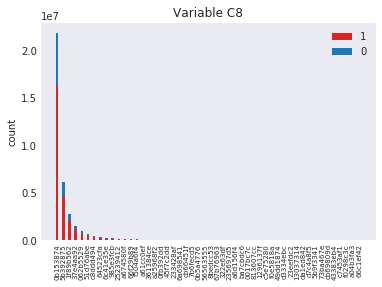

In [58]:
# Example plot in full data 
plot_category_counts(trainRDDCached, 'C8', var_position=20, top=50)

In [ ]:
# FULL DATA

for var_position, var in enumerate(FIELDS):

    if var_position>12 and var_position<39:
        print(" ")
        print("VARIABLE {}".format(var))
        print(" ")
        plot_category_counts(trainRDDCached, var, var_position=var_position, top=20)

## 4. Algorithm Implementation

## 5. Application of Course Concepts